In [4]:
# Important libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
np.random.seed(4440)

In [95]:
# Functions and Classies

func = lambda x: 1 / (1 + np.exp(-x))
dfdx = lambda x: func(x) * (1 - func(x))
# func = lambda x: np.tanh(x)
# dfdx = lambda x: 1 - np.tanh(x)**2

class Neuron():
    def __init__(self, activation_function=None, derived_activation_function=None):
        self.func = (lambda x: x) if not activation_function \
                                    else activation_function
        self.dfdx = (lambda x: 1) if not derived_activation_function \
                                    else derived_activation_function

        self.weights = dict()
        self.connections_from = []
        self.connections_to = []
        
        self.output = None
        self.input = None
        self.delta = None
        self.bias = None

    def output_calculation(self):
        if self.output == None:
            self.input = 0
            
            for neuron in self.connections_from:
                self.input += neuron.output_calculation()*self.weights[neuron]

            self.output = self.func(self.input + (self.bias if self.bias != None else 0))
        return self.output

    def delta_calculation(self):
        if self.delta == None:
            theSum = 0

            for neuron in self.connections_to:
                theSum += neuron.delta_calculation()*self.weights[neuron]
                
            self.delta = theSum*self.dfdx(self.input + (self.bias if self.bias != None else 0))
        return self.delta

    def weights_calibration(self, learning_rate):
        for neuron in self.connections_to:
            self.weights[neuron] += 2*learning_rate*self.output*neuron.delta
            neuron.weights[self] = self.weights[neuron]

    def bias_calibration(self, learning_rate):
        if self.bias is not None:
            self.bias += 2*learning_rate*self.delta

    def cleaningOutput(self):
        self.output = None

    def cleaningDelta(self):
        self.delta = None

    def set_weight(self, otherNeuron, weight):
        self.weights[otherNeuron] = weight
        otherNeuron.weights[self] = weight

    def set_Input(self, value):
        self.input = value
        self.output = self.func(value + (self.bias if self.bias != None else 0))

    def set_delta(self, value):
        self.delta = value

    def set_bias(self, value):
        self.bias = value


class Layer():
    def __init__(self, num_of_neurons, activation_function=None, derived_activation_function=None, bias=None):
        self.neurons = [Neuron(activation_function, derived_activation_function) 
                        for _ in range(num_of_neurons)]
        
        if bias is not None:
            self.setNeuronsBias(bias)

    def weightedConnectionsCreator(self, otherLayer, connections=None, weights=None):
        if not connections: connections = tuple((i,j) for i in range(len(self.neurons)) 
                                                for j in  range(len(otherLayer.neurons)))
        if not weights: weights = 2*np.random.rand(len(connections))-1
            
        for (ni,nj),w in zip(connections, weights):
            neuron_from = self.neurons[ni-1]
            neuron_to = otherLayer.neurons[nj-1]
            neuron_from.set_weight(neuron_to, w)
            neuron_from.connections_to.append(neuron_to)
            neuron_to.connections_from.append(neuron_from)

    def weightsBetweenLayersCalibration(self, learning_rate):
        for neuron in self.neurons:
            neuron.weights_calibration(learning_rate)

    def neurosBiasCalibration(self, learning_rate):
        for neuron in self.neurons:
            neuron.bias_calibration(learning_rate)

    def cleaningNeuronsOutput(self):
        for neuron in self.neurons:
            neuron.cleaningOutput()

    def cleaningNeuronsDelta(self):
        for neuron in self.neurons:
            neuron.cleaningDelta()

    def setNeuronsBias(self, values):
        for neuron, value in zip(self.neurons, values):
            neuron.set_bias(value)
        
    
class Network():
    def __init__(self, num_of_inputs, num_of_outputs, activation_function=None, 
                 derived_activation_function=None, bias=None):
        self.num_of_inputs = num_of_inputs
        self.num_of_outputs = num_of_outputs
        self.predictions = None
        self.mse_list = None
        self.mse = None
        self.layers = [Layer(self.num_of_inputs, 
                             derived_activation_function=derived_activation_function),
                       Layer(self.num_of_outputs, 
                             activation_function, derived_activation_function, bias)]
        self.layers[0].setNeuronsBias(self.num_of_inputs*[None])

    def add_HiddenLayer(self, layer):
        self.layers.insert(-1, layer)

    def weightedConnectionsBetweenLayers(self, num_of_layer_FromTo, 
                                         connections=None, weights=None):
        layer_from = self.layers[num_of_layer_FromTo[0]-1]
        layer_to = self.layers[num_of_layer_FromTo[1]-1]
        layer_from.weightedConnectionsCreator(layer_to, connections, weights)
    
    def predict(self, input_data, target_data=None):
        self.cleaningLayersNeuronsOutput()
        if input_data.size == self.num_of_inputs:
            for neuron, value in zip(self.layers[0].neurons, input_data): neuron.set_Input(value)    
            self.predictions = np.array([neuron.output_calculation() for neuron in self.layers[-1].neurons])
            if not target_data is None: self.predict_error(target_data)
            return self.predictions
            
        else: 
            self.predictions = np.array([self.predict(data)[0] for data in input_data])
            if not target_data is None:
                self.mse = sum(self.predict_error(target_data)**2)/len(target_data)
                return self.mse
            return self.predictions

    def predict_error(self, target_data):
        return target_data - self.predictions
    
    def calculation_of_deltas(self, target):
        for neuron, error in zip(self.layers[-1].neurons, 
                                 self.predict_error(target)):
            
            delta = error*neuron.dfdx(neuron.input + (neuron.bias if neuron.bias != None else 0))
            neuron.set_delta(delta)
        for neuron in self.layers[0].neurons:
            neuron.delta_calculation()
        
    def forward(self, input_data):
        for neuron, value in zip(self.layers[0].neurons, input_data): neuron.set_Input(value)   
        self.predictions = np.array([neuron.output_calculation() for neuron in self.layers[-1].neurons])
        return self.predictions
        
    def backward(self, learning_rate):
        for n in range(len(self.layers)-1):
            left = self.layers[n]
            right = self.layers[n+1]
            left.weightsBetweenLayersCalibration(learning_rate)
            right.neurosBiasCalibration(learning_rate)

    def cleaningLayersNeuronsOutput(self):
        for layer in self.layers:
            layer.cleaningNeuronsOutput()

    def cleaningLayersNeuronsDelta(self):
        for layer in self.layers:
            layer.cleaningNeuronsDelta()

    def train(self, train_data, target_data, learning_rate, tolerance, epochs=10**3):
        num_of_tdata = len(train_data)
        self.mse_list = []
        
        for epoch in range(epochs):
            self.mse = np.array([0. for _ in range(self.num_of_outputs)])
            
            for input_data, target in zip(train_data, target_data):
                self.cleaningLayersNeuronsOutput()
                self.forward(input_data)
                self.mse += self.predict_error(target)**2/num_of_tdata
                self.cleaningLayersNeuronsDelta()
                self.calculation_of_deltas(target)
                self.backward(learning_rate)
                
            self.mse_list.append(self.mse[0])
            if self.mse[0] < tolerance: break
        return self.mse_list

In [121]:
# Simulation

train_input = np.array([[0,0], [0,1], [1,0], [1,1]])
train_output =  np.array([[0], [1], [1], [0]])

epochs = 10**4
learning_rate = .2
tolerance = 0.001

NMC = 100
epochs_list = []

for N in range(NMC):
    Net = Network(2,1, func, dfdx, np.random.uniform(-1,1,1))
    Net.add_HiddenLayer(Layer(2, func, dfdx, np.random.uniform(-1,1,2)))
    Net.weightedConnectionsBetweenLayers((1,2))
    Net.weightedConnectionsBetweenLayers((2,3))
    
    mse_list = Net.train(train_input, train_output, 
                         learning_rate, tolerance, epochs)
    epochs_list.append(len(mse_list))

epochs_list = [epo for epo in epochs_list if epo != epochs]
mean_epochs = np.mean(epochs_list)
std_epochs = np.std(epochs_list)
    
print(f'Needed epochs = {mean_epochs:.1f} ± {std_epochs:.1f}')
print(f'Successes {len(epochs_list)}\n')

print('Last run')
print('Targets - Predictions')
print('---------------------')
for input,target in zip(train_input, train_output):
    print(f'{target[0]} - {Net.predict(input)[0]:.4f}')

print()
print("Weights")
for layer in Net.layers:
    print('-'*20)
    for neuron in layer.neurons:
        for n in neuron.connections_to:
            print(neuron.weights[n])

print()
print("Bias")
for layer in Net.layers[1:]:
    print('-'*20)
    for neuron in layer.neurons:
        print(neuron.bias)

Needed epochs = 5329.6 ± 929.3
Successes 78

Last run
Targets - Predictions
---------------------
0 - 0.0350
1 - 0.9700
1 - 0.9698
0 - 0.0310

Weights
--------------------
-5.643024572681586
5.368575007549946
5.468787383987025
-5.568497028492263
--------------------
8.25161568544646
8.23042583388854
--------------------

Bias
--------------------
-3.0131905852336587
-3.075767728012026
--------------------
-4.067307531603075


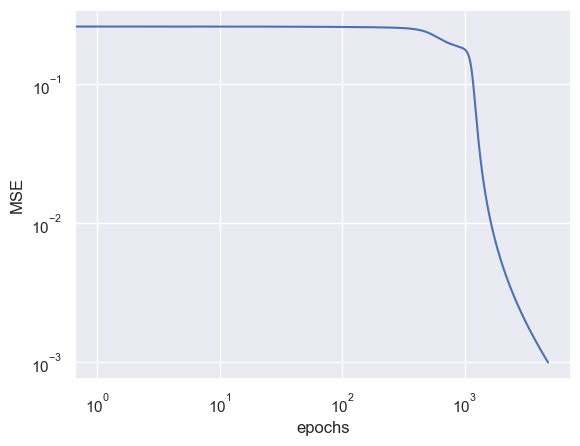

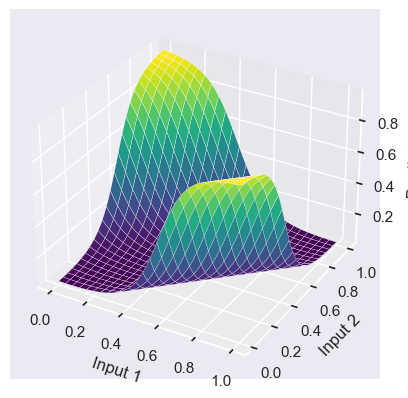

In [118]:
# visualization

sns.lineplot(mse_list)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.show()

nx = 50
ny = 50
x = np.linspace(0, 1, nx+1)
y = np.linspace(0, 1, ny+1)
X, Y = np.meshgrid(x, y)
Z = np.array([[Net.predict(np.array([i,j]))[0] for i in x] for j in y])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0.2)
ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Prediction')
plt.savefig('prediction_surface.png')
plt.show()